# open webcam and record

In [ ]:
import cv2
import dlib
import csv
import time

# Khởi tạo dlib và bộ nhận diện khuôn mặt
face_detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Mở webcam
cap = cv2.VideoCapture(0)

# Tạo file CSV để lưu dữ liệu
csv_file = open("eye_tracking_data.csv", mode="w", newline="")
csv_writer = csv.writer(csv_file)
csv_writer.writerow(["RecordingTime [ms]", "Point of Regard LeftX [px]", "Point of Regard Left Y [px]", "Point of Regard Right X [px]", "Point of Regard Right Y [px]"])

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_detector(gray)
    
    for face in faces:
        landmarks = landmark_predictor(gray, face)
        
        left_eye_x = (landmarks.part(36).x + landmarks.part(39).x) // 2
        left_eye_y = (landmarks.part(36).y + landmarks.part(39).y) // 2
        
        right_eye_x = (landmarks.part(42).x + landmarks.part(45).x) // 2
        right_eye_y = (landmarks.part(42).y + landmarks.part(45).y) // 2
        
        timestamp = time.time()
        csv_writer.writerow([timestamp, left_eye_x, left_eye_y, right_eye_x, right_eye_y])
        
        cv2.circle(frame, (left_eye_x, left_eye_y), 3, (0, 255, 0), -1)
        cv2.circle(frame, (right_eye_x, right_eye_y), 3, (0, 255, 0), -1)
    
    cv2.imshow("Eye Tracking", frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
csv_file.close()


In [ ]:
import cv2
import dlib
import numpy as np

# 1. Khởi tạo detector và predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("core\shape_predictor_68_face_landmarks.dat")

# 2. Hàm lấy trung tâm pupil và tỉ lệ gaze
def get_pupil_center_and_ratios(eye_landmarks, frame_gray):
    # Tạo mask cho vùng mắt
    mask = np.zeros(frame_gray.shape, dtype=np.uint8)
    cv2.fillPoly(mask, [np.array(eye_landmarks, dtype=np.int32)], 255)
    eye_region = cv2.bitwise_and(frame_gray, frame_gray, mask=mask)

    # Threshold để cô lập pupil (màu tối)
    _, thresh = cv2.threshold(eye_region, 40, 255, cv2.THRESH_BINARY_INV)

    # Tìm contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None, None, None

    # Chọn contour lớn nhất
    c = max(contours, key=cv2.contourArea)
    (cx, cy), radius = cv2.minEnclosingCircle(c)
    cx, cy, radius = int(cx), int(cy), int(radius)

    # Tỉ lệ ngang/dọc trong bounding rect của mắt
    x_coords = [p[0] for p in eye_landmarks]
    y_coords = [p[1] for p in eye_landmarks]
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    h_ratio = (cx - x_min) / (x_max - x_min)  # 0 = nhìn trái, 1 = nhìn phải
    v_ratio = (cy - y_min) / (y_max - y_min)  # 0 = nhìn trên, 1 = nhìn dưới

    return (cx, cy, radius), h_ratio, v_ratio

# 3. Bắt đầu đọc webcam
cap = cv2.VideoCapture(0)
screen_w, screen_h = 1920, 1080  # Ví dụ: độ phân giải màn hình

while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    for face in faces:
        shape = predictor(gray, face)
        # Lấy mắt trái (36–41) và mắt phải (42–47)
        left_eye = [(shape.part(i).x, shape.part(i).y) for i in range(36, 42)]
        right_eye= [(shape.part(i).x, shape.part(i).y) for i in range(42, 48)]

        # Tính pupil center và ratios
        left_result  = get_pupil_center_and_ratios(left_eye, gray)
        right_result = get_pupil_center_and_ratios(right_eye, gray)

        for eye_landmarks, result in [(left_eye, left_result), (right_eye, right_result)]:
            if result[0] is None:
                continue
            (cx, cy, r), h_ratio, v_ratio = result

            # Vẽ vòng tròn quanh pupil
            cv2.circle(frame, (cx, cy), r, (0,255,0), 2)
            # Vẽ box mắt
            pts = np.array(eye_landmarks, np.int32)
            cv2.polylines(frame, [pts], True, (255,0,0), 1)

            # Chuyển ratio thành tọa độ màn hình (gaze estimation)
            gaze_x = int(h_ratio * screen_w)
            gaze_y = int(v_ratio * screen_h)
            # Vẽ điểm nhìn ước tính
            cv2.circle(frame, (gaze_x//4, gaze_y//4), 5, (0,0,255), -1)
            # (chú ý scale nhỏ để vừa khung hình webcam)

            # Hiển thị tỉ lệ
            cv2.putText(frame, f"H:{h_ratio:.2f} V:{v_ratio:.2f}", (cx-30, cy-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1)

    cv2.imshow("Gaze Tracking", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


# Read image from csv, draw scanpath

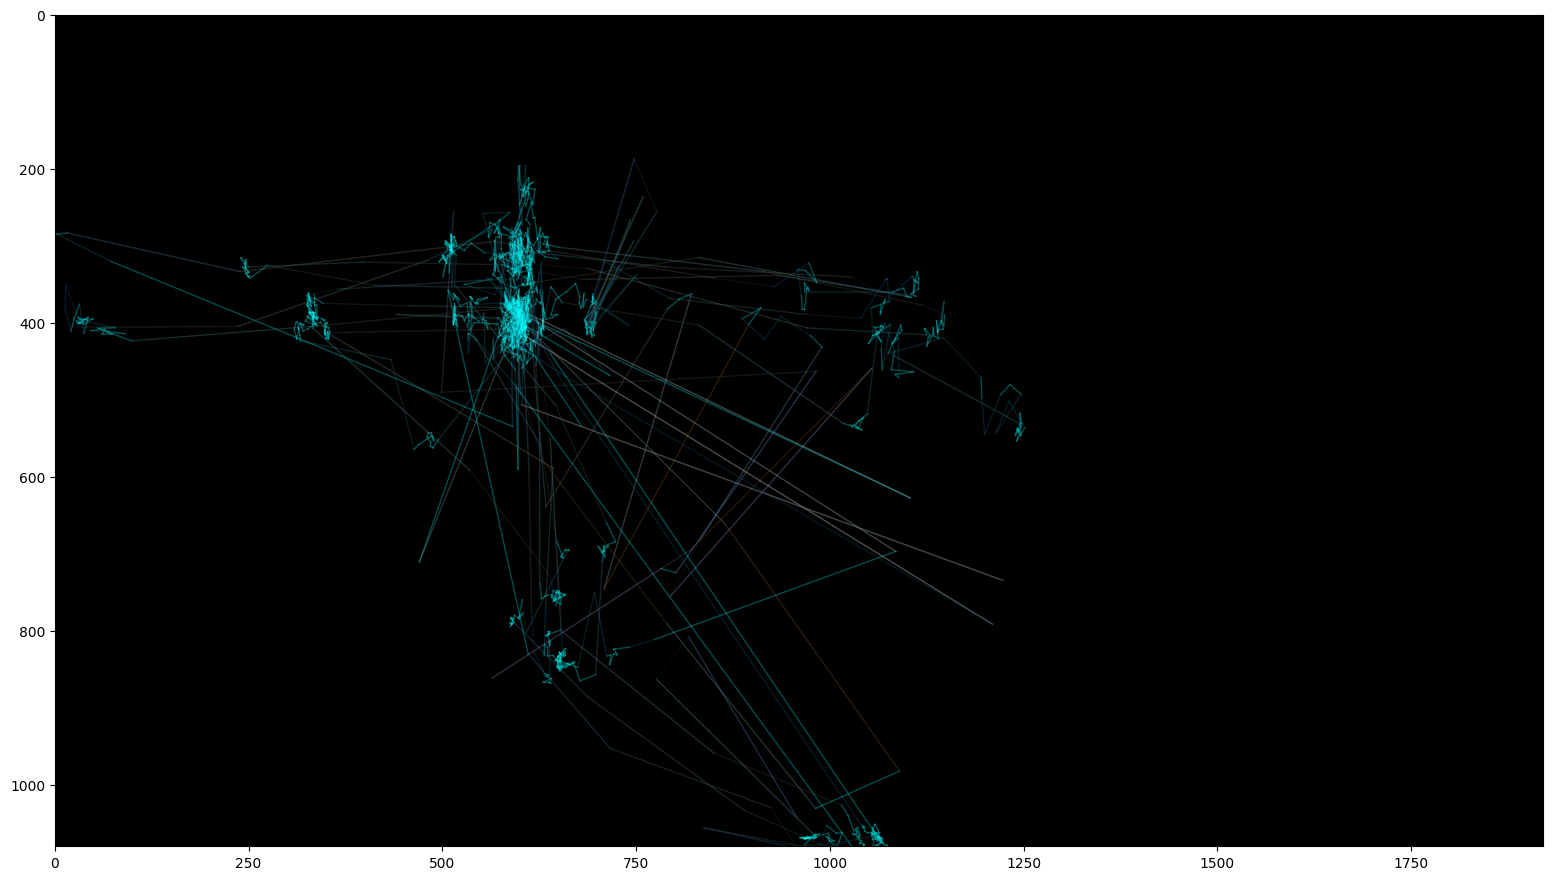

: 

In [ ]:
import csv
import math
import matplotlib.pyplot as plt
import numpy as np

def read_csv(file_path):
    data = []
    with open(file_path, newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
                x_value = row["Point of Regard Right X [px]"]
                y_value = row["Point of Regard Right Y [px]"]
                try:
                    if x_value == "-" or y_value == "-":
                        continue
                    if float(x_value) == 0 and float(y_value) == 0:
                        continue
                    data.append({
                        "timestamp": float(row["RecordingTime [ms]"]),
                        "x": float(x_value),
                        "y": float(y_value)
                    })
                except ValueError:
                    continue
    return data

def exponential_moving_average(data, alpha):
    smoothed = [data[0]]
    for i in range(1, len(data)):
        prev = smoothed[-1]
        curr = data[i]
        smoothed.append({
            "timestamp": curr["timestamp"],
            "x": alpha * curr["x"] + (1 - alpha) * prev["x"],
            "y": alpha * curr["y"] + (1 - alpha) * prev["y"]
        })
    return smoothed

def euclidean_distance(p1, p2):
    return math.hypot(p2["x"] - p1["x"], p2["y"] - p1["y"])

def normalize(value, min_val, max_val):
    return np.clip((value - min_val) / (max_val - min_val), 0, 1)

def calculate_velocity_acceleration_jerk(data):
    velocities, accelerations, jerks = [], [], []
    
    # Tính toán vận tốc, gia tốc và độ giật
    for i in range(len(data) - 1):
        dt = max(data[i+1]["timestamp"] - data[i]["timestamp"], 1e-6)
        d = euclidean_distance(data[i], data[i+1])
        velocities.append(d / dt)
    
    for i in range(1, len(velocities)):
        dt = max(data[i+1]["timestamp"] - data[i]["timestamp"], 1e-6)
        accelerations.append((velocities[i] - velocities[i-1]) / dt)
    
    for i in range(1, len(accelerations)):
        dt = max(data[i+2]["timestamp"] - data[i+1]["timestamp"], 1e-6)
        jerks.append((accelerations[i] - accelerations[i-1]) / dt)
    
    return velocities, accelerations, jerks

def render_scanpath(data, velocities, accelerations, jerks, alpha_line, skip_n=5, output_file=None):
    fig, ax = plt.subplots(figsize=(19.2, 10.8), dpi=100)
    ax.set_facecolor("black")
    plt.xlim(0, 1920)
    plt.ylim(0, 1080)
    plt.gca().invert_yaxis()

    v_min, v_max = min(velocities), max(velocities)
    a_min, a_max = min(accelerations), max(accelerations)
    j_min, j_max = min(jerks), max(jerks)
    
    for i in range(0, len(data) - 1, skip_n):  # Bỏ qua mỗi n đoạn đường
        p1, p2 = data[i], data[i+1]
        v = velocities[i]
        a = accelerations[i-1] if i-1 >= 0 else 0
        j = jerks[i-2] if i-2 >= 0 else 0
        
        # Xác định màu sắc dựa trên vận tốc và độ giật
        if v < 1.47 and abs(a)< 62:
            color = (0, 1, 1)  # Màu cyan cho vận tốc thấp và ít giật
        else:
            r = normalize(v, v_min, v_max)
            g = normalize(a, a_min, a_max)
            b = normalize(j, j_min, j_max)
            color = (r, g, b)
        
        plt.plot([p1["x"], p2["x"]], [p1["y"], p2["y"]], 
                 color=color, linewidth=1, alpha=alpha_line)
    
    # plt.title("non-ASD", color="black")

    # Lưu đồ thị nếu có output_file
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight', transparent=False)
    else:
        plt.show()

def main():
    file_path = "management\\6-Trinh Minh Tam\\17h01-14-apr-2025\\1.csv"
    raw_data = read_csv(file_path)
    smoothed_data = exponential_moving_average(raw_data, alpha=0.9)
    velocities, accelerations, jerks = calculate_velocity_acceleration_jerk(smoothed_data)
    render_scanpath(smoothed_data, velocities, accelerations, jerks, alpha_line=0.3, skip_n=1, output_file="path_output.png")

if __name__ == "__main__":
    main()


# Read img and diagnose


In [14]:
from tensorflow.keras.models import load_model
new_model = load_model('core/best.h5')

In [ ]:
img = cv2.imread(r'path_output.png')
pltimshow(img)
plt.show()

AttributeError: module 'matplotlib' has no attribute 'imshow'

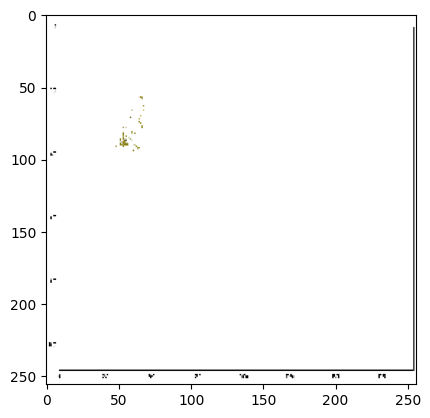

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [7]:
yhat_new = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 5s 5s/step


In [ ]:
if yhat_new > 0.5: 
    print(f'Predicted class is non-ASD')
else:
3    print(f'Predicted class is ASD')

Predicted class is non-ASD


# TEST WITH CORE

In [17]:
import matplotlib.pyplot as plt
from core import *

In [ ]:
img = "management\\1-Minh Duc Do Xuan\\0h19-09-apr-2025\scanpath_diagnosed.png"
img = diagnose_image(img)
plt.show(img.num)

1/1 [==============================] - 0s 32ms/step


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()